In [64]:
# Import requirements and read the merged spreadsheet from the data clean
require(survey)
require(ggplot2)

mergeddata = read.csv('/Users/mbrumfield/Documents/depression_ds/mergeddata.csv')
head(mergeddata, 5)

,X,SEQN,DEPRESSED,AGEGRP,MARITALSTATUS,PIR,GENDER,RACE,EDUCATION,WTMEC2YR,WTINT2YR,SDMVPSU,SDMVSTRA
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,83732,0,2,1,2,1,2,4,135629.51,134671.37,1,125
2,1,83733,0,1,2,1,1,2,2,25282.43,24328.56,1,125
3,2,83734,0,2,1,2,1,2,2,12575.84,12400.01,1,131
4,3,83735,1,2,4,3,2,2,4,102078.63,102718.00,1,131
5,4,83736,0,1,2,1,2,3,3,18234.74,17627.67,2,126


      0    1
            
1  1452  144
2  1560  157
3  1017   88
4   701   43

    DEPRESSED
RACE         0         1
   1  30776502   2679522
   2 131666194  10518621
   3  22653717   2035299
   4  17962868   1398980

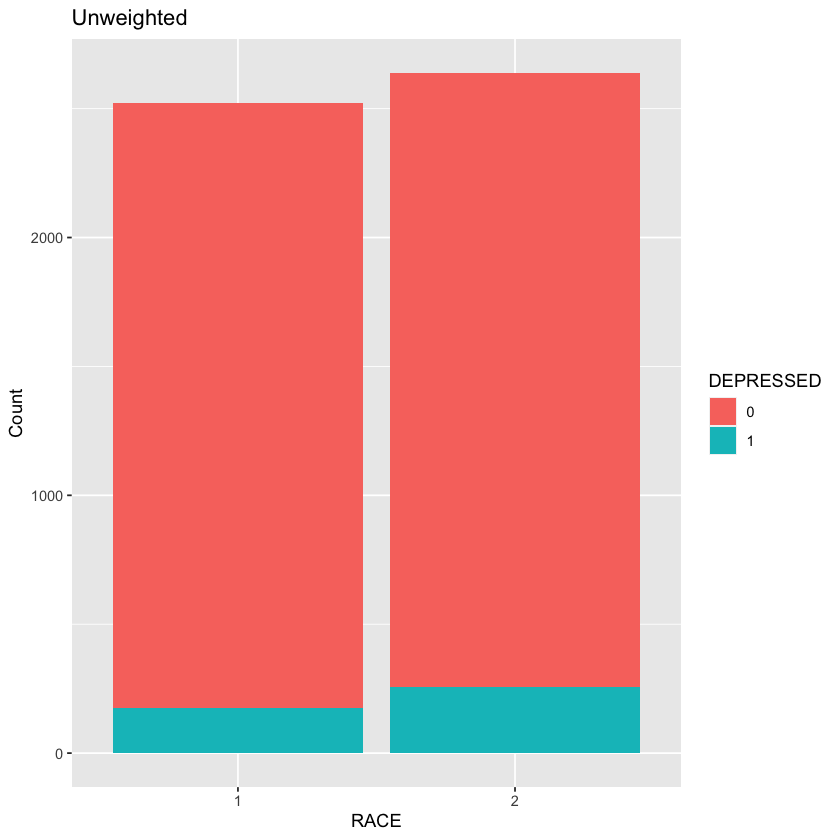

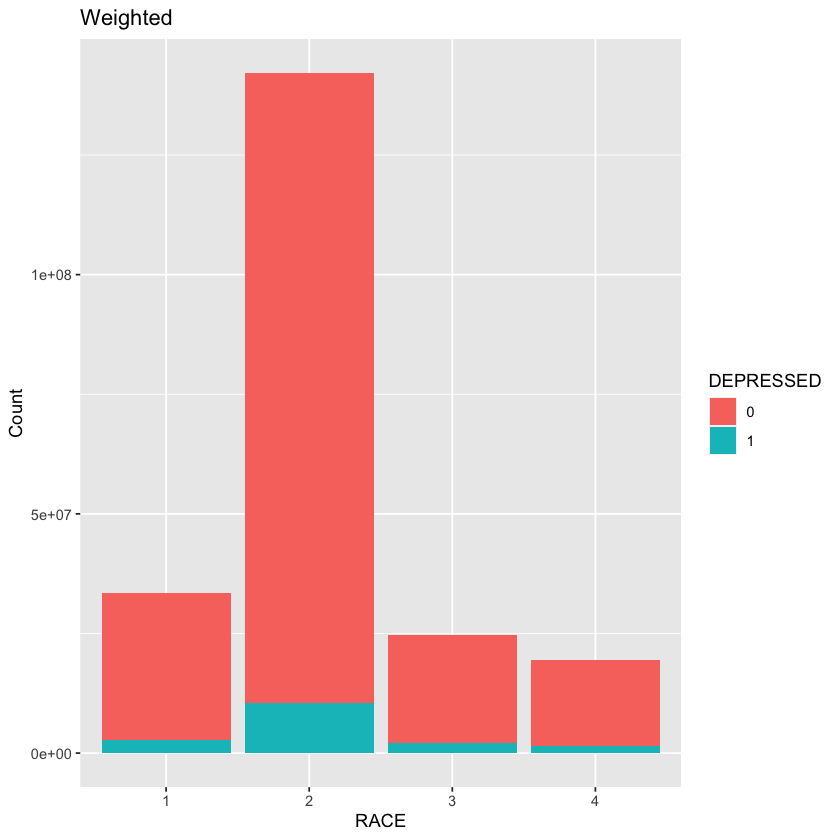

In [65]:
#Creates two way table of counts by Race and Depression
unweightedTable = ftable(mergeddata$RACE, mergeddata$DEPRESSED)
unweightedTable

#Specify survey design
merergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~RACE + DEPRESSED, merergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("RACE", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = RACE, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "RACE", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("RACE", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = RACE, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "RACE", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [66]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

    DEPRESSED
RACE         0         1
   1  30776502   2679522
   2 131666194  10518621
   3  22653717   2035299
   4  17962868   1398980

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~RACE + DEPRESSED, design = merergeddatadesign, statistic = "Chisq")
X-squared = 0.81156, df = 3, p-value = 0.9174


      0    1
            
1  2349  174
2  2381  258

      DEPRESSED
GENDER         0         1
     1 100850792   6049836
     2 102208488  10582586

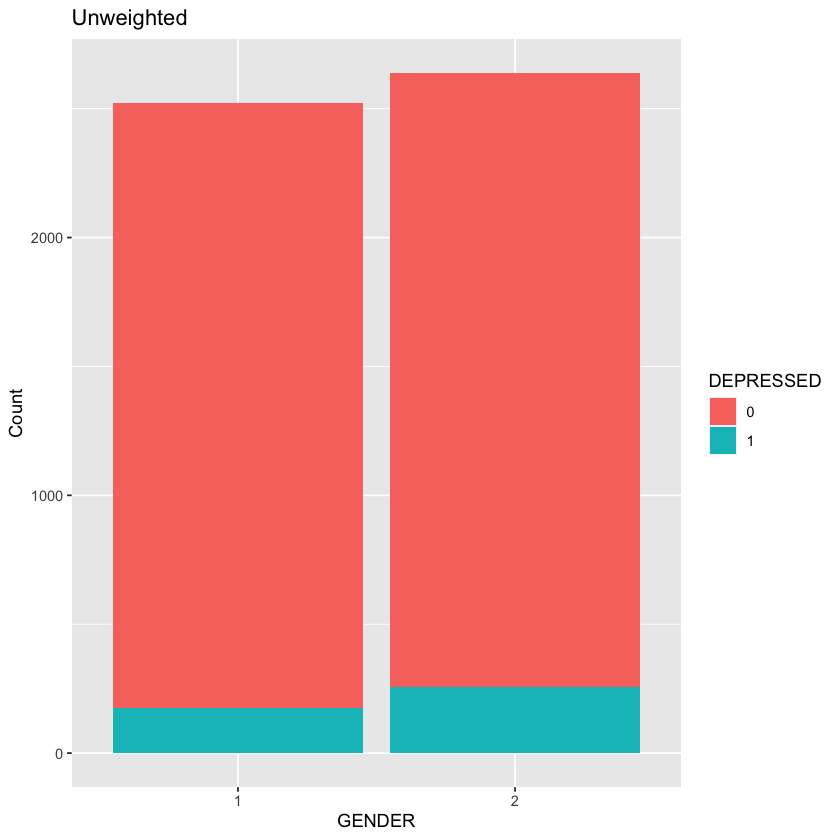

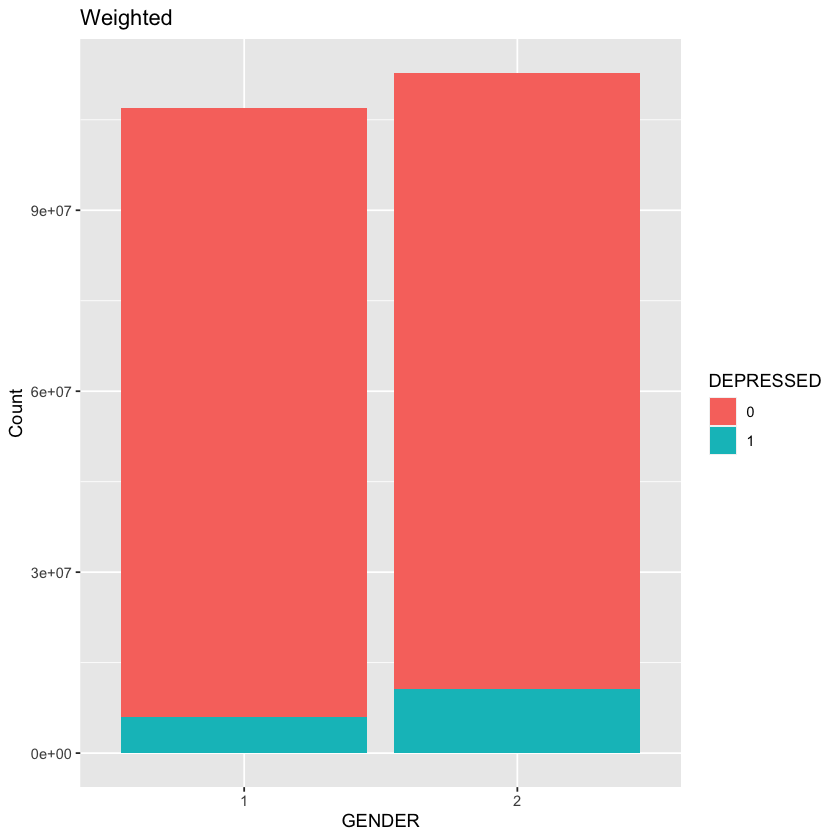

In [67]:
#Creates two way table of counts by Gender and Depression
unweightedtable = ftable(mergeddata$GENDER, mergeddata$DEPRESSED)
unweightedtable

#Specify survey design
mergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~GENDER + DEPRESSED, mergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("GENDER", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = GENDER, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "GENDER", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("GENDER", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = GENDER, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "GENDER", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [68]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

      DEPRESSED
GENDER         0         1
     1 100850792   6049836
     2 102208488  10582586

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~GENDER + DEPRESSED, design = mergeddatadesign, statistic = "Chisq")
X-squared = 25.546, df = 1, p-value = 2.623e-05


      0    1
            
1  2931  254
2  1799  178

      DEPRESSED
AGEGRP         0         1
     1 132057223  10921227
     2  71002057   5711196

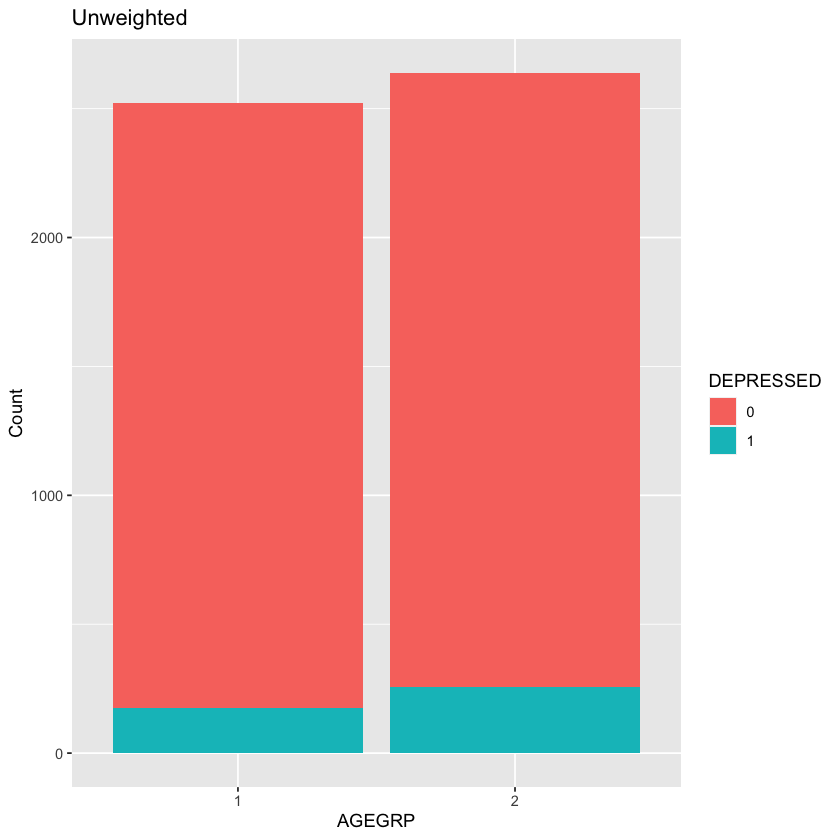

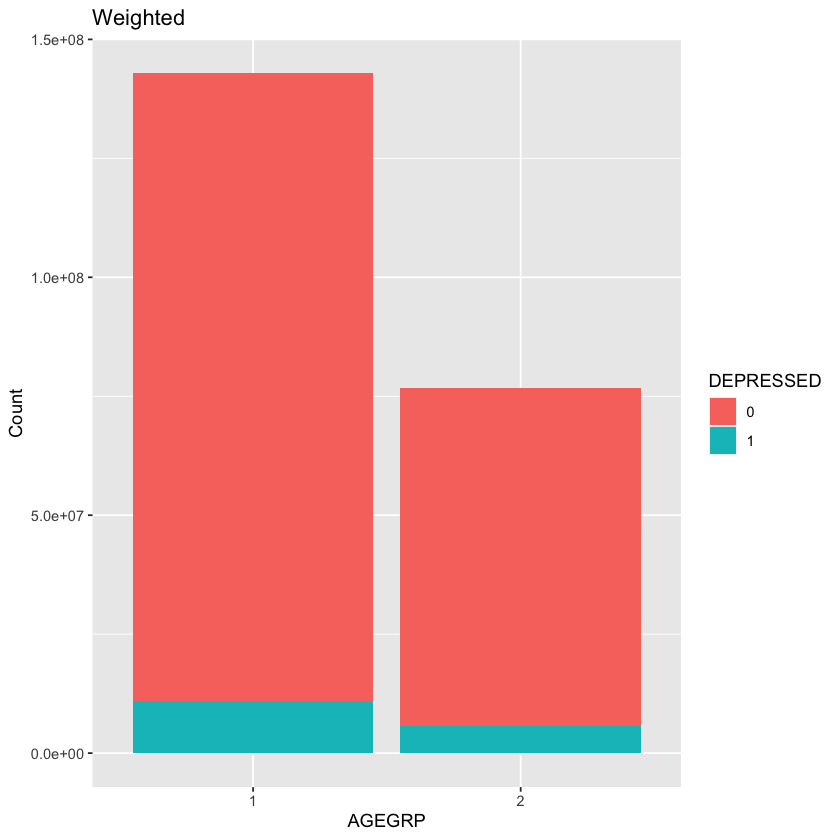

In [69]:
#Creates two way table of counts by Race and Depression
unweightedTable = ftable(mergeddata$AGEGRP, mergeddata$DEPRESSED)
unweightedTable

#Specify survey design
merergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~AGEGRP + DEPRESSED, merergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("AGEGRP", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = AGEGRP, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "AGEGRP", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("AGEGRP", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = AGEGRP, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "AGEGRP", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [70]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

      DEPRESSED
AGEGRP         0         1
     1 132057223  10921227
     2  71002057   5711196

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~AGEGRP + DEPRESSED, design = merergeddatadesign, statistic = "Chisq")
X-squared = 0.062776, df = 1, p-value = 0.8621


      0    1
            
1  1057  143
2  1107  108
3  1399  131
4  1167   50

         DEPRESSED
EDUCATION        0        1
        1 27675163  3530044
        2 43460491  4302435
        3 66072930  5851696
        4 65850696  2948247

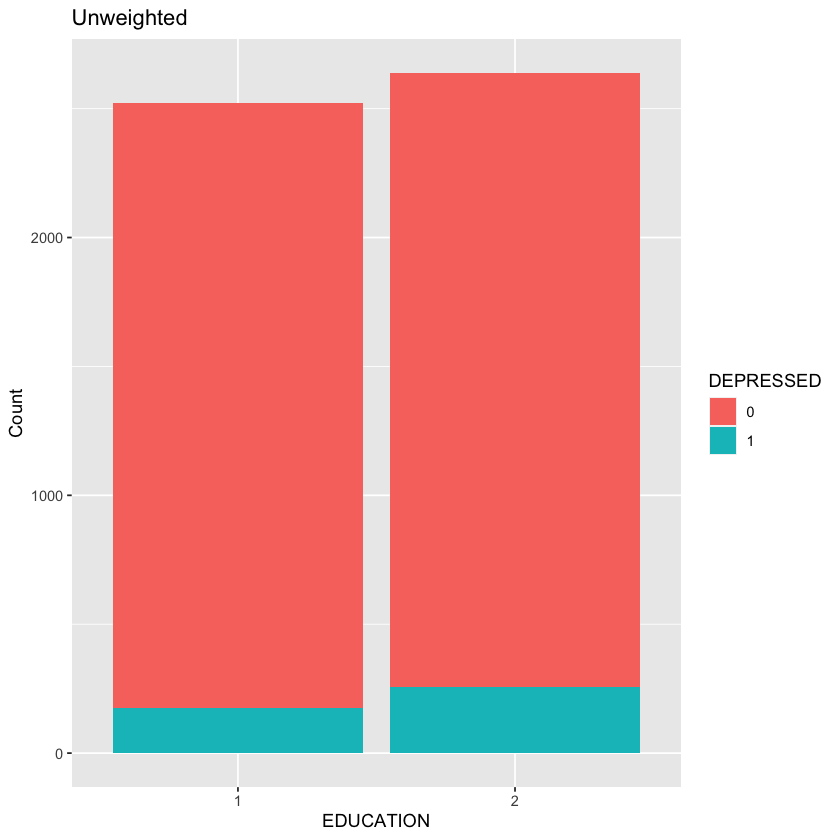

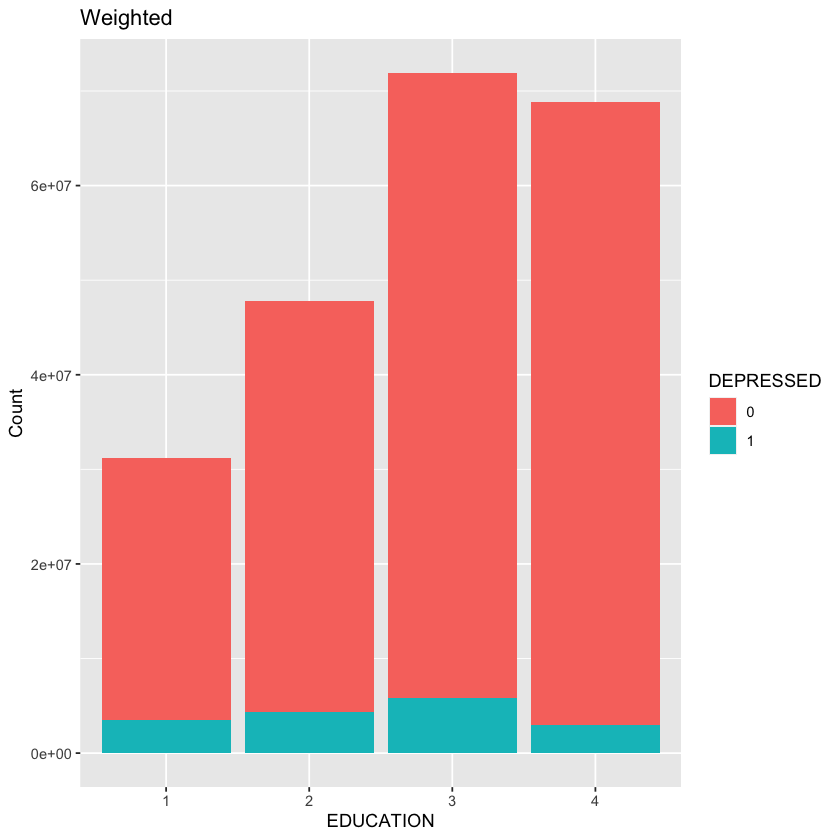

In [71]:
#Creates two way table of counts by Race and Depression
unweightedTable = ftable(mergeddata$EDUCATION, mergeddata$DEPRESSED)
unweightedTable

#Specify survey design
merergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~EDUCATION + DEPRESSED, merergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("EDUCATION", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = EDUCATION, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "EDUCATION", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("EDUCATION", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = EDUCATION, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "EDUCATION", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [72]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

         DEPRESSED
EDUCATION        0        1
        1 27675163  3530044
        2 43460491  4302435
        3 66072930  5851696
        4 65850696  2948247

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~EDUCATION + DEPRESSED, design = merergeddatadesign,     statistic = "Chisq")
X-squared = 43.688, df = 3, p-value = 4.421e-05


      0    1
            
1  2333  141
2   934  129
3   797  105
4   666   57

             DEPRESSED
MARITALSTATUS         0         1
            1 111174658   5551591
            2  33867941   4852090
            3  33740768   3987727
            4  24275914   2241014

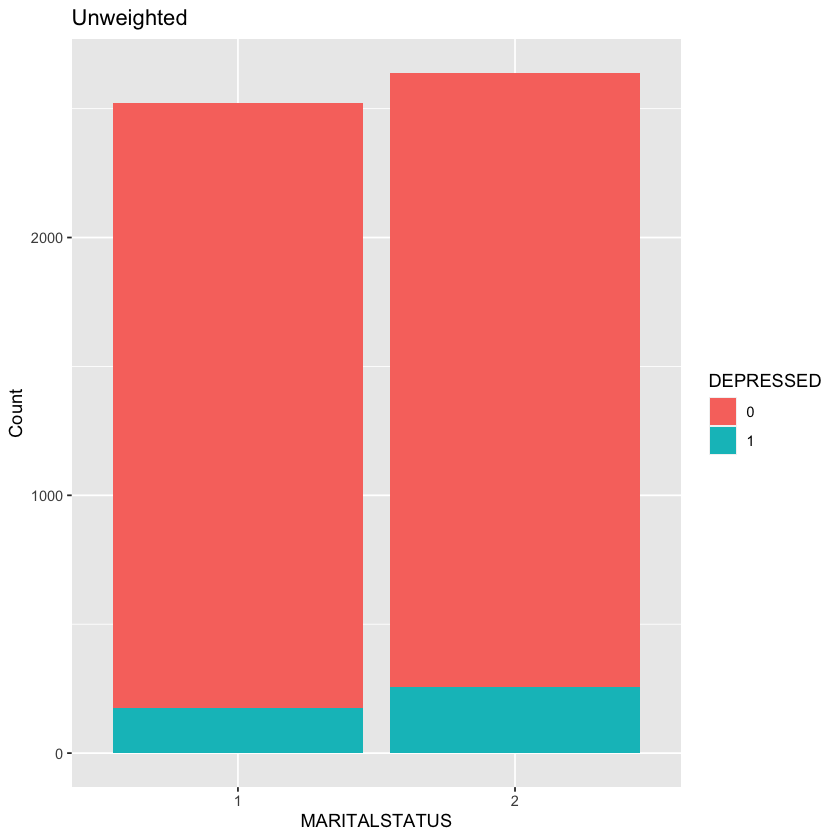

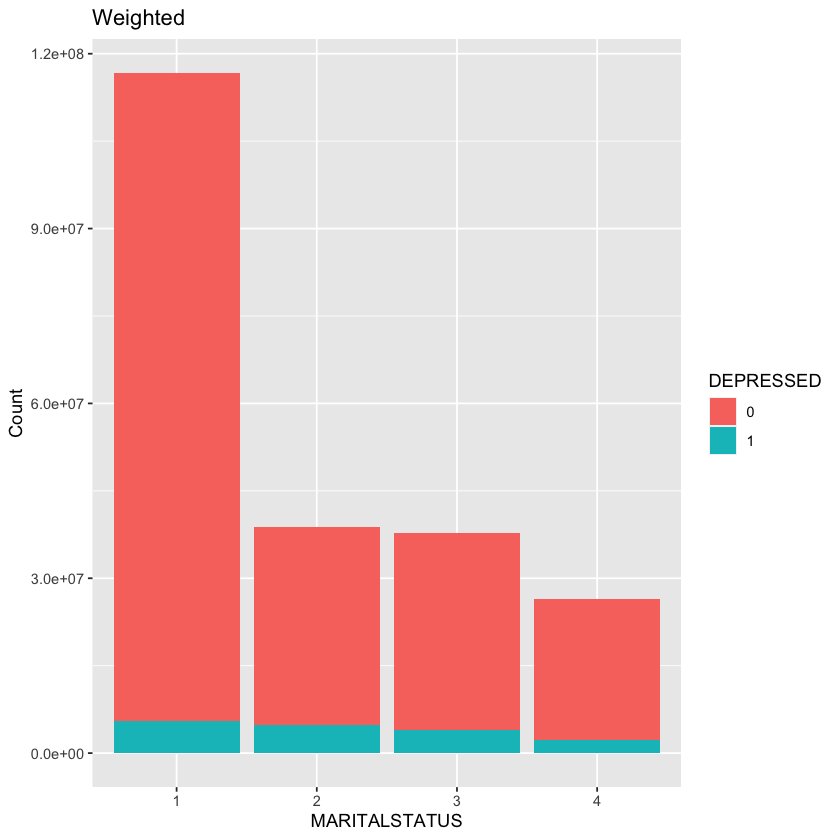

In [73]:
#Creates two way table of counts by Race and Depression
unweightedTable = ftable(mergeddata$MARITALSTATUS, mergeddata$DEPRESSED)
unweightedTable

#Specify survey design
merergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~MARITALSTATUS + DEPRESSED, merergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("MARITALSTATUS", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = MARITALSTATUS, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "MARITALSTATUS", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("MARITALSTATUS", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = MARITALSTATUS, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "MARITALSTATUS", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [74]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

             DEPRESSED
MARITALSTATUS         0         1
            1 111174658   5551591
            2  33867941   4852090
            3  33740768   3987727
            4  24275914   2241014

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~MARITALSTATUS + DEPRESSED, design = merergeddatadesign,     statistic = "Chisq")
X-squared = 75.125, df = 3, p-value < 2.2e-16


      0    1
            
1  1863  259
2  2146  154
3   721   19

   DEPRESSED
PIR        0        1
  1 54060430  7930215
  2 96540812  6978407
  3 52458039  1723801

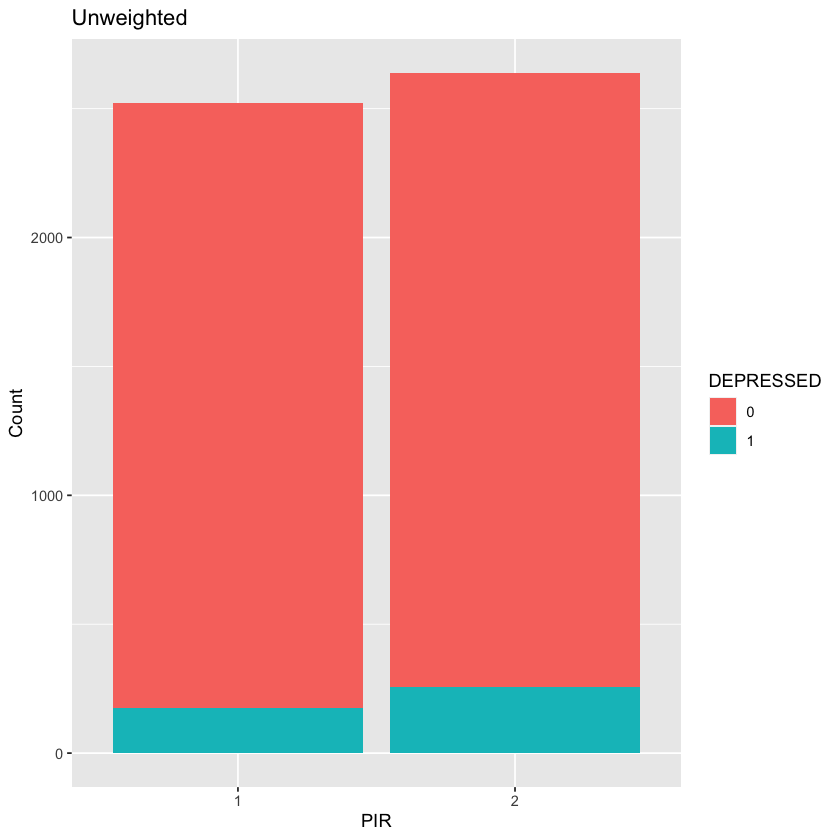

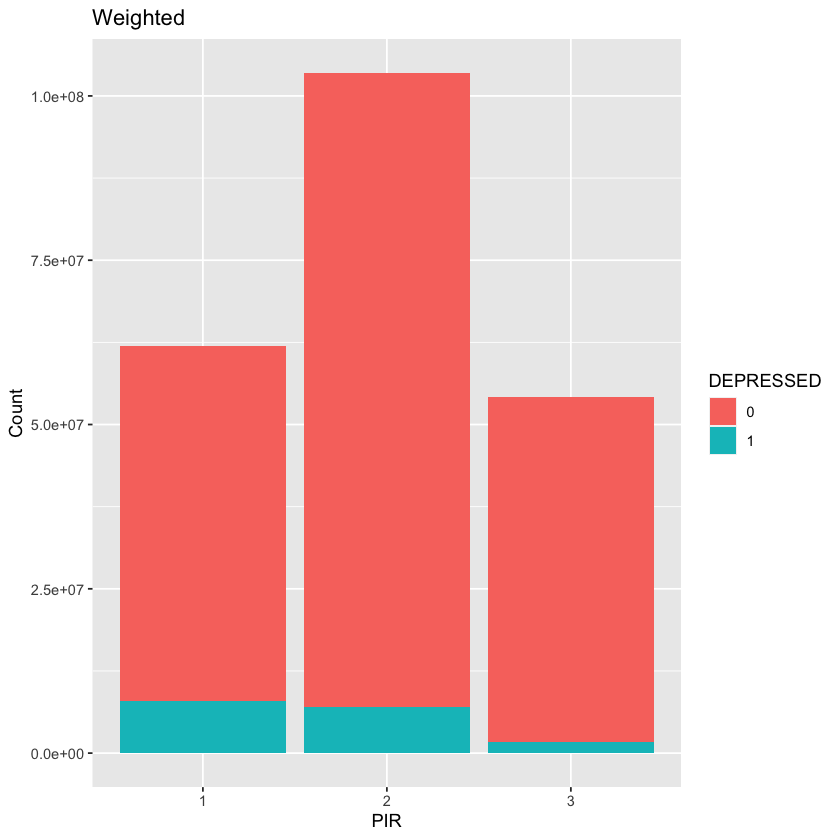

In [75]:
#Creates two way table of counts by Race and Depression
unweightedTable = ftable(mergeddata$PIR, mergeddata$DEPRESSED)
unweightedTable

#Specify survey design
merergeddatadesign = svydesign(id=~SDMVPSU, strata=~SDMVSTRA, nest=TRUE, data=mergeddata, weights=mergeddata$WTMEC2YR)

#Create your two‐way table
weightedtable = svytable(~PIR + DEPRESSED, merergeddatadesign) 
weightedtable

#Converts unweightedtable into data frame to be used with ggplot()
unweighteddata = as.data.frame(unweightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(unweighteddata) = c("PIR", "DEPRESSED", "Count")

ggplot(unweighteddata, aes(x = PIR, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "PIR", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Unweighted")

#Converts weightedtable into a data frame to be used with ggplot()
weighteddata = as.data.frame(weightedtable)

#Assigns the column names Gender, Home_Ownership, and Counts to the data frame
colnames(weighteddata) = c("PIR", "DEPRESSED", "Count")

ggplot(weighteddata, aes(x = PIR, y = Count, fill = DEPRESSED)) + 
    geom_bar(
        #position = "fill",
        stat = "identity") +
    #scale_y_continuous(labels = percent_format()) +
    labs(x = "PIR", y = "Count", fill = "DEPRESSED") + 
    ggtitle("Weighted")

In [76]:
# For the Rao‐Scott correction, we use the weighted tables from the RW section and run a chi‐
# square test using equation [2]. However, we also take into accound weight variability by doing a
# few more calculations.
summary(weightedtable, statistic = "Chisq")

   DEPRESSED
PIR        0        1
  1 54060430  7930215
  2 96540812  6978407
  3 52458039  1723801

	Pearson's X^2: Rao & Scott adjustment

data:  svychisq(~PIR + DEPRESSED, design = merergeddatadesign, statistic = "Chisq")
X-squared = 94.2, df = 2, p-value = 3.18e-11
